In [ ]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Replace file paths as appropriate

In [ ]:
# Loading file paths
#train_path = f'E:/CMAPSS/data/train_FD00X.txt'
#test_path = f'E:/CMAPSS/data/test_FD00X.txt'
train_path = f'D:/Data Science/CMAPSS Engine Simulations/Data/train_FD00X.txt'
test_path = f'D:/Data Science/CMAPSS Engine Simulations/Data/test_FD00X.txt'


"""Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16."""
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']
labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors


# Functions


In [104]:
# Preparing files
def load_data(filepath):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    for i in range(1, 5):
        data.append(pd.read_csv(filepath.replace('X', str(i)),
                                names=labels, delimiter='\s+',
                                dtype=np.float32))
        if i == 1 or i == 3:
            data[i - 1].drop(cols_to_drop, axis=1, inplace=True)
        if i == 4 or i == 2:
            data[i - 1].drop('sensor16', axis=1, inplace=True)
    return data  # a list


def prepare_data(data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    rul = pd.DataFrame(data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    data = data.merge(rul, on=['unit'], how='left')

    data['RUL'] = data['max'] - data['cycles']
    data.drop('max', axis=1, inplace=True)
    return data


def create_training_sequence(df, seq_length, seq_cols):
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)


def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]


def create_training_batch(df, seq_length, columns):
    x = np.concatenate(list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for unit in df['unit'].unique()))
    y = np.concatenate(list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for unit in df['unit'].unique()))
    return x, y

def create_test_batch(df, seq_length, columns):
    x = np.concatenate(list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for unit in df['unit'].unique()))
    y = np.concatenate(list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for unit in df['unit'].unique()))
    return x, y

In [113]:
# Initialising data
train_data = load_data(train_path)
test_data = load_data(test_path)

for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])
    test_data[i] = prepare_data(test_data[i])

scalers = [MinMaxScaler(feature_range=(-1, 1)),
           MinMaxScaler(feature_range=(-1, 1)),
           MinMaxScaler(feature_range=(-1, 1)),
           MinMaxScaler(feature_range=(-1, 1))]


for scaler in range(0, 4):
    train_data[scaler].iloc[:, 2:-1] = scalers[scaler].fit_transform(train_data[scaler].iloc[:, 2:-1])
    test_data[scaler].iloc[:, 2:-1] = scalers[scaler].transform(test_data[scaler].iloc[:, 2:-1])



# Initialising data

In [109]:
sequence_len = 10

FD001 = train_data[0]
FD002 = train_data[1]
FD003 = train_data[2]
FD004 = train_data[3]

x_FD001_columns = [column for column in FD001 if column != 'RUL']
x_FD002_columns = [column for column in FD002 if column != 'RUL']
x_FD003_columns = [column for column in FD003 if column != 'RUL']
x_FD004_columns = [column for column in FD004 if column != 'RUL']

x_train_FD001, y_train_FD001 = create_training_batch(FD001, sequence_len, x_FD001_columns)
x_train_FD002, y_train_FD002 = create_training_batch(FD002, sequence_len, x_FD002_columns)
x_train_FD003, y_train_FD003 = create_training_batch(FD003, sequence_len, x_FD003_columns)
x_train_FD004, y_train_FD004 = create_training_batch(FD004, sequence_len, x_FD004_columns)


# Creating and training 4 different models for 4 different test trajectories
## Trajectory FD001

In [84]:
feature_count = x_train_FD001.shape[2]  
out_dim = 1

model = Sequential()
model.add(Input(shape=(sequence_len, feature_count)))
model.add(LSTM(
    units=64,
    return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(
    units=64,
    return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=out_dim, activation='relu'))
model.add(Activation('relu'))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 10, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 128 (512.00 B)

In [85]:

history = model.fit(x_train_FD001, y_train_FD001, epochs=20, batch_size=64, validation_split=0.2, verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/20
213/213 - 10s - 46ms/step - loss: 6997.6382 - mse: 6997.6382 - val_loss: 5986.7666 - val_mse: 5986.7666
Epoch 2/20
213/213 - 3s - 14ms/step - loss: 5192.8125 - mse: 5192.8125 - val_loss: 4442.2695 - val_mse: 4442.2695
Epoch 3/20
213/213 - 3s - 14ms/step - loss: 3822.7302 - mse: 3822.7302 - val_loss: 3216.4158 - val_mse: 3216.4158
Epoch 4/20
213/213 - 3s - 14ms/step - loss: 2712.4731 - mse: 2712.4731 - val_loss: 2221.4414 - val_mse: 2221.4414
Epoch 5/20
213/213 - 3s - 15ms/step - loss: 1865.1846 - mse: 1865.1846 - val_loss: 1470.7124 - val_mse: 1470.7124
Epoch 6/20
213/213 - 3s - 14ms/step - loss: 1224.7056 - mse: 1224.7056 - val_loss: 921.9256 - val_mse: 921.9256
Epoch 7/20
213/213 - 3s - 15ms/step - loss: 756.2135 - mse: 756.2135 - val_loss: 536.6704 - val_mse: 536.6704
Epoch 8/20
213/213 - 3s - 14ms/step - loss: 450.5482 - mse: 450.5482 - val_loss: 280.8080 - val_mse: 280.8080
Epoch 9/20
213/213 - 3s - 13ms/step - loss: 257.0932 - mse: 257.0932 - val_loss: 122.2734 - val_m

## Trajectory FD002


In [ ]:
feature_count2 = x_train_FD002.shape[2]  

model2 = Sequential()
model2.add(Input(shape=(sequence_len, feature_count2)))
model2.add(LSTM(
    units=64,
    return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(LSTM(
    units=64,
    return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(units=out_dim, activation='relu'))
model2.add(Activation('relu'))
model2.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model2.summary()

In [ ]:
history2 = model2.fit(x_train_FD002, y_train_FD002, epochs=20, batch_size=64, validation_split=0.2, verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

## Trajectory FD003


In [71]:
feature_count3 = x_train_FD003.shape[2]  

model3 = Sequential()
model3.add(Input(shape=(sequence_len, feature_count3)))
model3.add(LSTM(
    units=64,
    return_sequences=True))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(LSTM(
    units=64,
    return_sequences=False))
model3.add(Dropout(0.3))
model3.add(Dense(units=out_dim, activation='relu'))
model3.add(Activation('relu'))
model3.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 10, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 128 (512.00 B)

In [86]:
history3 = model3.fit(x_train_FD003, y_train_FD003, epochs=20, batch_size=64, validation_split=0.2, verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/20
267/267 - 10s - 36ms/step - loss: 11508.3105 - mse: 11508.3105 - val_loss: 9882.2500 - val_mse: 9882.2500
Epoch 2/20
267/267 - 4s - 14ms/step - loss: 8599.4248 - mse: 8599.4248 - val_loss: 7448.2129 - val_mse: 7448.2129
Epoch 3/20
267/267 - 4s - 13ms/step - loss: 6344.9087 - mse: 6344.9087 - val_loss: 5460.2358 - val_mse: 5460.2358
Epoch 4/20
267/267 - 4s - 13ms/step - loss: 4551.1685 - mse: 4551.1685 - val_loss: 3787.3660 - val_mse: 3787.3660
Epoch 5/20
267/267 - 4s - 14ms/step - loss: 3161.1641 - mse: 3161.1641 - val_loss: 2562.2092 - val_mse: 2562.2092
Epoch 6/20
267/267 - 4s - 13ms/step - loss: 2078.3750 - mse: 2078.3750 - val_loss: 1587.2418 - val_mse: 1587.2418
Epoch 7/20
267/267 - 4s - 14ms/step - loss: 1307.2380 - mse: 1307.2380 - val_loss: 929.2969 - val_mse: 929.2969
Epoch 8/20
267/267 - 4s - 13ms/step - loss: 790.6713 - mse: 790.6713 - val_loss: 501.7637 - val_mse: 501.7637
Epoch 9/20
267/267 - 4s - 14ms/step - loss: 463.7581 - mse: 463.7581 - val_loss: 303.0002 -

## Trajectory FD004

In [78]:
feature_count4 = x_train_FD004.shape[2]  

model4 = Sequential()
model4.add(Input(shape=(sequence_len, feature_count4)))
model4.add(LSTM(
    units=64,
    return_sequences=True))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(LSTM(
    units=64,
    return_sequences=False))
model4.add(Dropout(0.3))

model4.add(Dense(units=out_dim, activation='relu'))
model4.add(Activation('relu'))
model4.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model4.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 10, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,257 (219.75 KB)

 Non-trainable params: 128 (512.00 B)

In [83]:
history4 = model4.fit(x_train_FD004, y_train_FD004, epochs=20, batch_size=64, validation_split=0.2, verbose=2,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/20
928/928 - 19s - 20ms/step - loss: 19307.1738 - mse: 19307.1738 - val_loss: 13039.5469 - val_mse: 13039.5469
Epoch 2/20
928/928 - 13s - 14ms/step - loss: 8922.4766 - mse: 8922.4766 - val_loss: 5300.7354 - val_mse: 5300.7354
Epoch 3/20
928/928 - 13s - 14ms/step - loss: 3318.7871 - mse: 3318.7871 - val_loss: 1834.0970 - val_mse: 1834.0970
Epoch 4/20
928/928 - 13s - 14ms/step - loss: 940.7693 - mse: 940.7693 - val_loss: 391.6669 - val_mse: 391.6669
Epoch 5/20
928/928 - 13s - 14ms/step - loss: 342.4012 - mse: 342.4012 - val_loss: 57.1654 - val_mse: 57.1654
Epoch 6/20
928/928 - 13s - 14ms/step - loss: 269.3433 - mse: 269.3433 - val_loss: 27.7262 - val_mse: 27.7262
Epoch 7/20
928/928 - 13s - 14ms/step - loss: 249.4969 - mse: 249.4969 - val_loss: 126.2551 - val_mse: 126.2551
Epoch 8/20
928/928 - 13s - 14ms/step - loss: 236.9421 - mse: 236.9421 - val_loss: 37.1943 - val_mse: 37.1943
Epoch 9/20
928/928 - 13s - 14ms/step - loss: 232.9281 - mse: 232.9281 - val_loss: 135.7601 - val_mse: 

In [87]:
model.save('D:/Data Science/CMAPSS Engine Simulations/Models/LSTM1.keras')
model2.save('D:/Data Science/CMAPSS Engine Simulations/Models/LSTM2.keras')
model3.save('D:/Data Science/CMAPSS Engine Simulations/Models/LSTM3.keras')
model4.save('D:/Data Science/CMAPSS Engine Simulations/Models/LSTM4.keras')
checkpoint1 = ModelCheckpoint('D:/Data Science/CMAPSS Engine Simulations/LSTM1.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
checkpoint2 = ModelCheckpoint('D:/Data Science/CMAPSS Engine Simulations/LSTM2.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
checkpoint3 = ModelCheckpoint('D:/Data Science/CMAPSS Engine Simulations/LSTM3.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
checkpoint4 = ModelCheckpoint('D:/Data Science/CMAPSS Engine Simulations/LSTM4.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

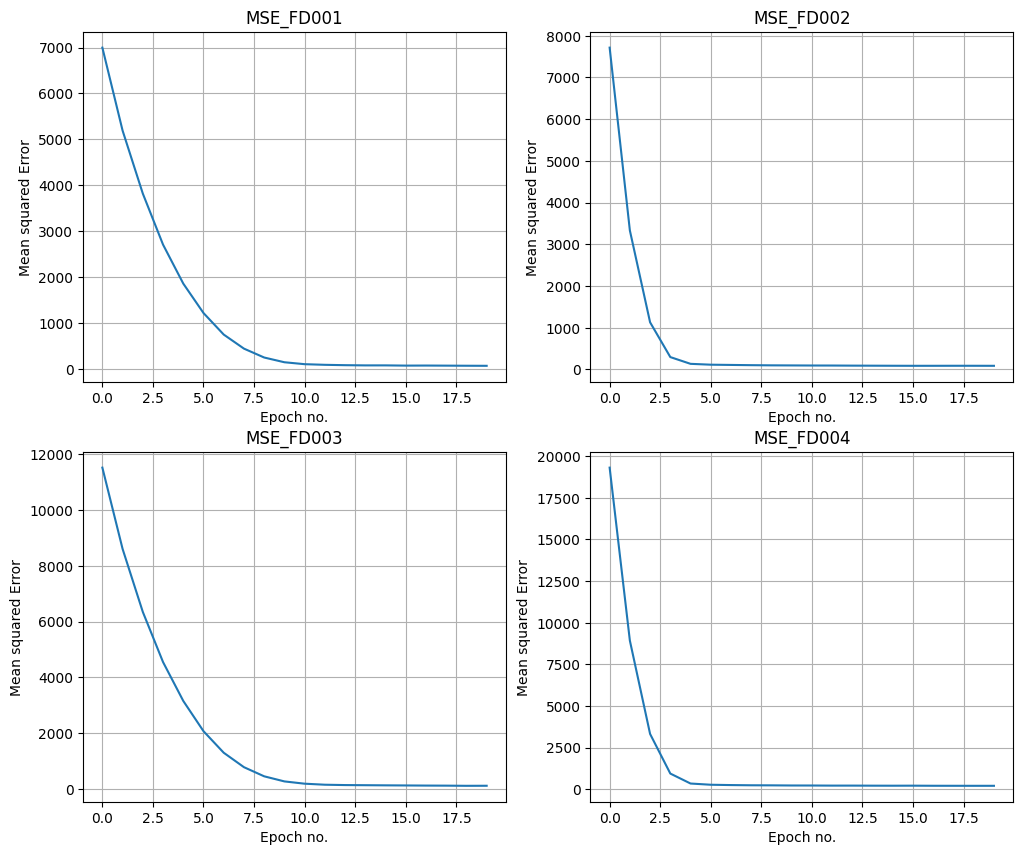

In [88]:
fig, axs = plt.subplots(2,2, figsize=(12,10))

axs[0, 0].plot(history.history['mse'])
axs[0, 0].set_title('MSE_FD001')
axs[0, 0].set_ylabel('Mean squared Error')
axs[0, 0].set_xlabel('Epoch no.')
axs[0, 0].grid()

axs[0, 1].plot(history2.history['mse'])
axs[0, 1].set_title('MSE_FD002')
axs[0, 1].set_ylabel('Mean squared Error')
axs[0, 1].set_xlabel('Epoch no.')
axs[0, 1].grid()

axs[1, 0].plot(history3.history['mse'])
axs[1, 0].set_title('MSE_FD003')
axs[1, 0].set_ylabel('Mean squared Error')
axs[1, 0].set_xlabel('Epoch no.')
axs[1, 0].grid()

axs[1, 1].plot(history4.history['mse'])
axs[1, 1].set_title('MSE_FD004')
axs[1, 1].set_ylabel('Mean squared Error')
axs[1, 1].set_xlabel('Epoch no.')
axs[1, 1].grid()


In [92]:
scores = model.evaluate(x_train_FD001, y_train_FD001, verbose=1, batch_size=200)
scores2 = model2.evaluate(x_train_FD002, y_train_FD002, verbose=1, batch_size=200)
scores3 = model3.evaluate(x_train_FD003, y_train_FD003, verbose=1, batch_size=200)
scores4 = model4.evaluate(x_train_FD004, y_train_FD004, verbose=1, batch_size=200)

print('MSE_FD001: {}'.format(scores[1]))
print('MSE_FD002: {}'.format(scores2[1]))
print('MSE_FD003: {}'.format(scores3[1]))
print('MSE_FD004: {}'.format(scores4[1]))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.4977 - mse: 17.4977
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.7387 - mse: 8.7387
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.0551 - mse: 64.0551
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 18.1980 - mse: 18.1980
MSE_FD001: 17.50617027282715
MSE_FD002: 8.758307456970215
MSE_FD003: 64.9207534790039
MSE_FD004: 18.17574119567871


Text(0, 0.5, 'RUL')

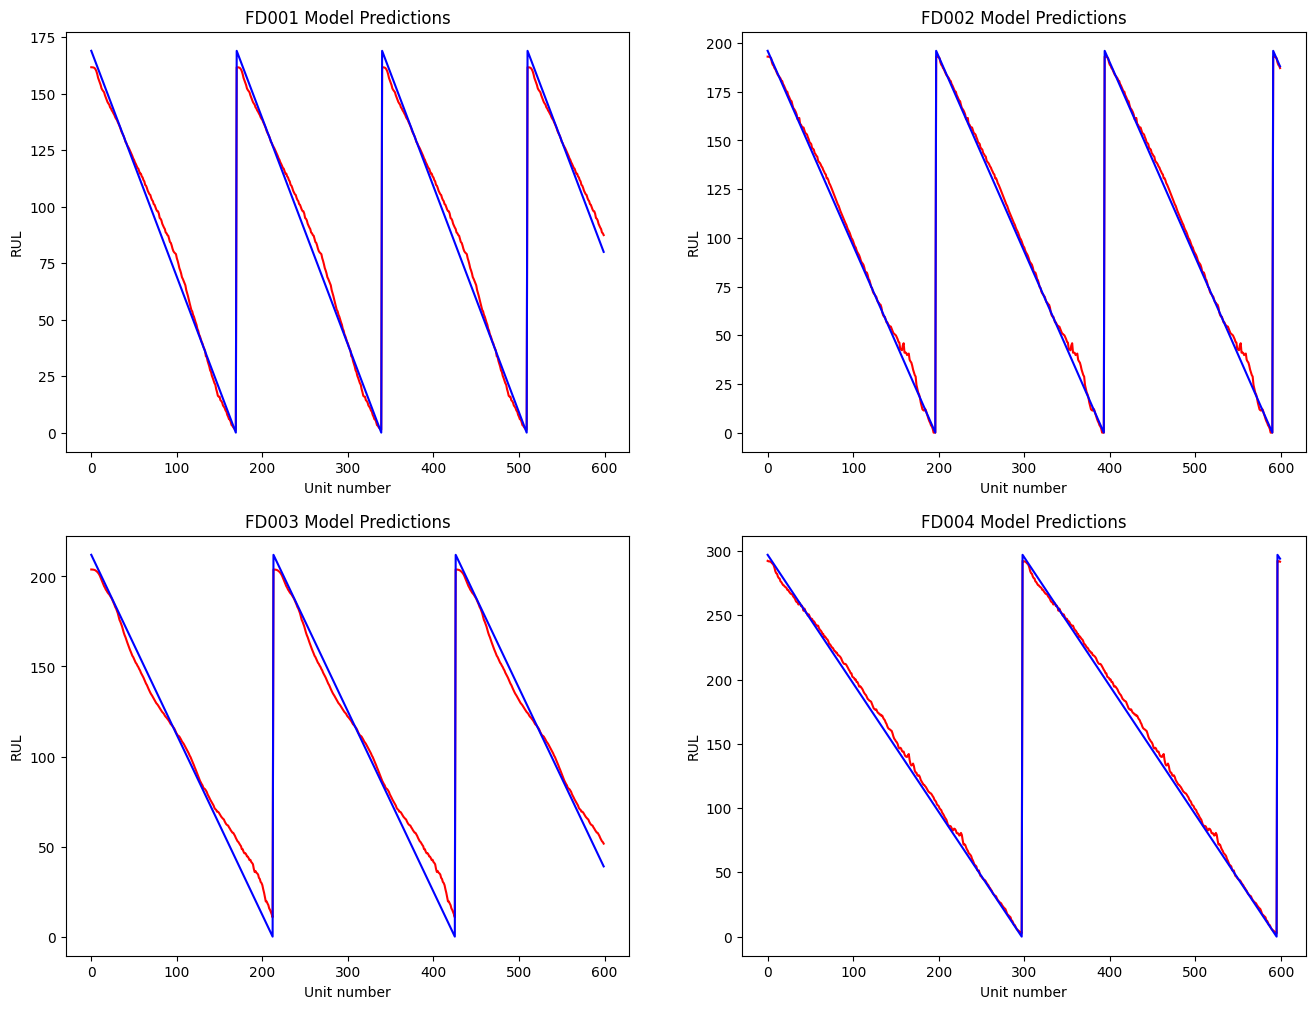

In [101]:
y_pred_test = model.predict(x_train_FD001[0:600], verbose=0)
y_pred_test2 = model2.predict(x_train_FD002[0:600], verbose=0)
y_pred_test3 = model3.predict(x_train_FD003[0:600], verbose=0)
y_pred_test4 = model4.predict(x_train_FD004[0:600], verbose=0)

fig1, axs1 = plt.subplots(2,2, figsize=(16, 12))
axs1[0, 0].plot(y_pred_test, color='red', label='Prediction')
axs1[0, 0].plot(y_train_FD001[0:600], color='blue', label='Ground Truth')
axs1[0, 0].set_title('FD001 Model Predictions')
axs1[0, 0].set_xlabel('Unit number')
axs1[0, 0].set_ylabel('RUL')

axs1[0, 1].plot(y_pred_test2, color='red', label='Prediction')
axs1[0, 1].plot(y_train_FD002[0:600], color='blue', label='Ground Truth')
axs1[0, 1].set_title('FD002 Model Predictions')
axs1[0, 1].set_xlabel('Unit number')
axs1[0, 1].set_ylabel('RUL')

axs1[1, 0].plot(y_pred_test3, color='red', label='Prediction')
axs1[1, 0].plot(y_train_FD003[0:600], color='blue', label='Ground Truth')
axs1[1, 0].set_title('FD003 Model Predictions')
axs1[1, 0].set_xlabel('Unit number')
axs1[1, 0].set_ylabel('RUL')

axs1[1, 1].plot(y_pred_test4, color='red', label='Prediction')
axs1[1, 1].plot(y_train_FD004[0:600], color='blue', label='Ground Truth')
axs1[1, 1].set_title('FD004 Model Predictions')
axs1[1, 1].set_xlabel('Unit number')
axs1[1, 1].set_ylabel('RUL')



# Applying models on real data

In [116]:
FD001_test = create_test_batch(test_data[0], 10, x_FD001_columns)
FD002_test = test_data[1]
FD003_test = test_data[2]
FD004_test = test_data[3]

print(test_data[0])
#y1 = model.predict(FD001_test[0:600], verbose=0)
#y2 = model2.predict(FD002_test[0:600], verbose=0)
#y3 = model3.predict(FD003_test[0:600], verbose=0)
#y4 = model4.predict(FD004_test[0:600], verbose=0)


        unit  cycles   opMode1   opMode2   sensor2   sensor3   sensor4  \
0        1.0     1.0  0.264368  0.500000  0.090363 -0.378677 -0.461178   
1        1.0     2.0 -0.310345 -0.500000 -0.698792 -0.240898 -0.555367   
2        1.0     3.0  0.034483  0.166667 -0.246979 -0.306740 -0.355507   
3        1.0     4.0  0.482759  0.000000 -0.259064 -0.429695 -0.183998   
4        1.0     5.0  0.160920  0.000000 -0.216888 -0.295837 -0.335922   
...      ...     ...       ...       ...       ...       ...       ...   
13091  100.0   194.0  0.563218  0.000000  0.222870  0.238716  0.132343   
13092  100.0   195.0 -0.126437 -0.166667  0.210815  0.074776  0.343685   
13093  100.0   196.0 -0.068966 -0.500000  0.343353 -0.035973 -0.170498   
13094  100.0   197.0 -0.436782  0.166667  0.234924  0.044258  0.252869   
13095  100.0   198.0  0.149425  0.500000  0.048187  0.333336  0.442944   

        sensor7   sensor8   sensor9  sensor11  sensor12  sensor13  sensor14  \
0      0.304352 -0.575195 -0.744